# ROI Segmentation
In this notebook i will try to segment just the go board from the image \
I will be using findings from notebook from path `./notebooks/2024-01-03-edges.ipynb`

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

def imshow(img, size=(5, 5)):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.rcParams['figure.figsize'] = size
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.show()

IMAGE_PATH = "../data/static/"

imgs = [cv.imread(IMAGE_PATH + img) for img in os.listdir(IMAGE_PATH) if img.split('.')[-1] in ['jpg', 'jpeg', 'png']]

def line_filter(gray):
    def line_filter_aux(img, kernel):
        down = cv.filter2D(gray, cv.CV_8U, kernel)
        up = cv.filter2D(gray, cv.CV_8U, np.flip(kernel))
        thup = cv.threshold(up, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
        thdown = cv.threshold(down, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
        dup = cv.dilate(thup, np.ones((3,3), np.uint8))
        ddown = cv.dilate(thdown, np.ones((3,3), np.uint8))
        AND = cv.bitwise_and(dup, ddown)
        return AND

    sobel_kernel = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])

    a = line_filter_aux(gray, sobel_kernel.T)
    b = line_filter_aux(gray, sobel_kernel)
    AND = cv.bitwise_and(a, b) 
    OR = cv.bitwise_or(a, b)
    return AND, OR

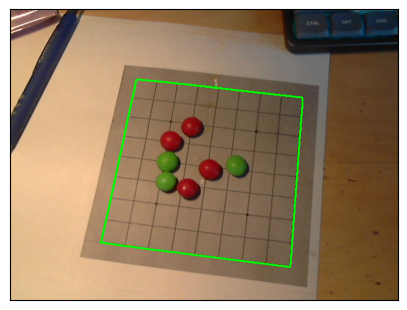

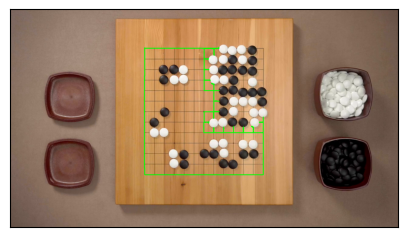

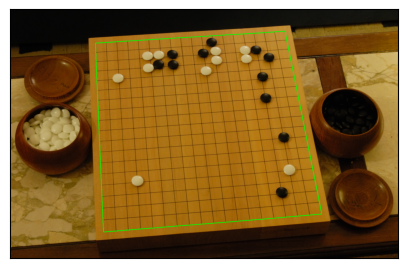

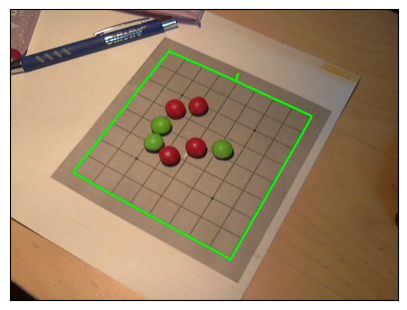

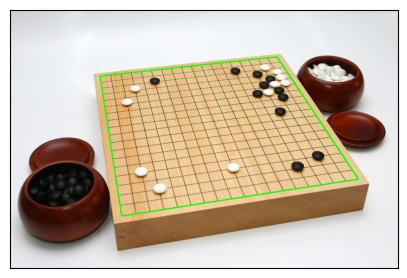

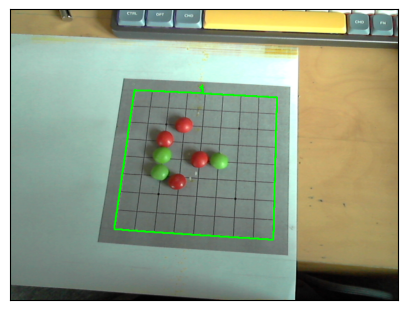

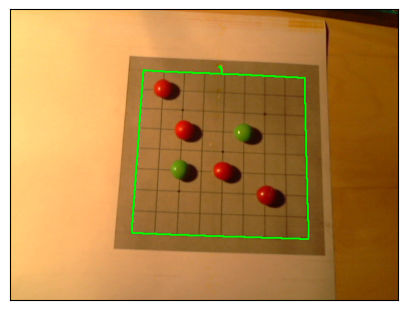

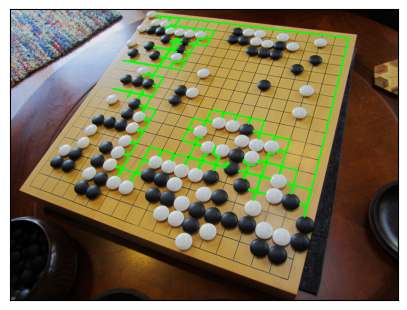

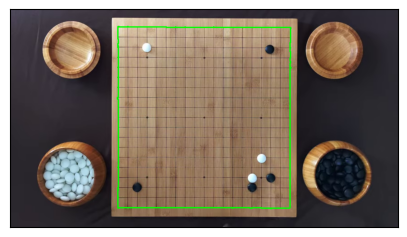

In [3]:
for img in imgs:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    AND, OR = line_filter(gray)
    # find contours
    contours, hierarchy = cv.findContours(OR, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    biggest = max(contours, key=lambda x: cv.contourArea(x))
    img_contours = img.copy()
    cv.drawContours(img_contours, [biggest], -1, (0, 255, 0), 2)
    imshow(img_contours)

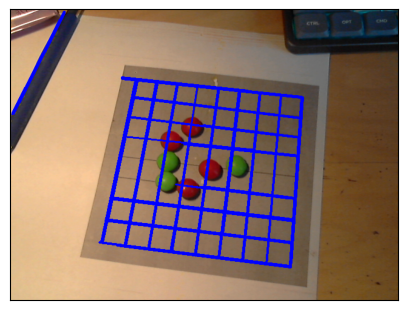

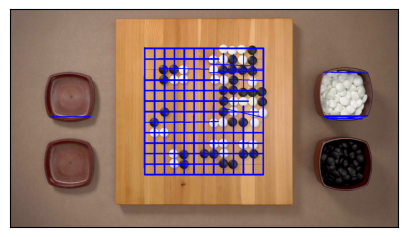

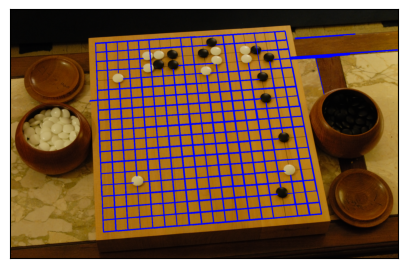

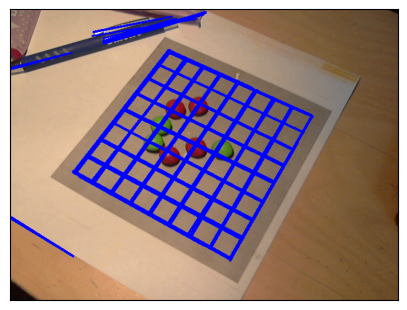

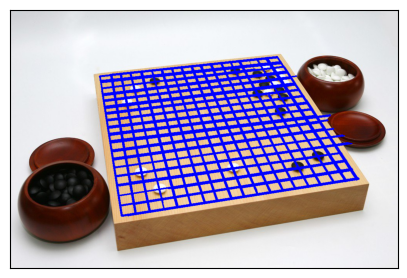

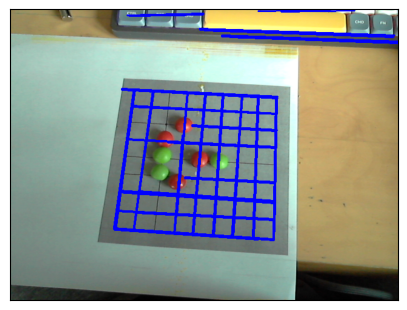

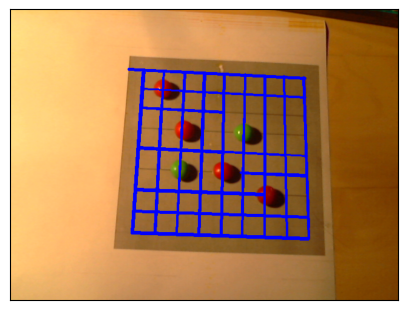

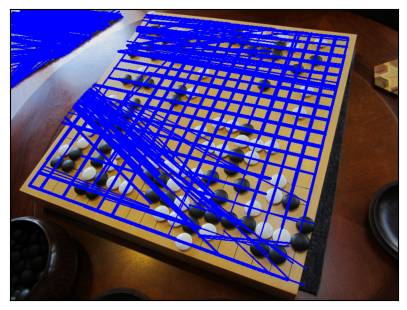

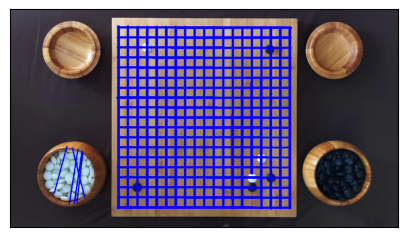

In [88]:
def draw_lines(img, lines):
    if lines is None:
        return img
    imgc = img.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(imgc, (x1, y1), (x2, y2), 255, 2) 
    return imgc


for img in imgs:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    AND, OR = line_filter(gray)
    dilated = cv.dilate(OR, np.ones((3,3), np.uint8))
    lines = cv.HoughLinesP(dilated, 1, np.pi/180, 100, minLineLength=100, maxLineGap=30)
    imshow(draw_lines(img, lines))
        

Clearly it seems that tuning the parameters of HoughLinesP will be crucial to get the best results \
Let's try to use these lines as new contours and see if we can find a good ROI

In [91]:
def approximate_quadriliteral(img):
    """Try to find four lines in the contour"""
    lines = cv.HoughLines(img, 1, np.pi/180, 250)
    print(len(lines))
    return lines

In [89]:
def draw_lines_polar(img, lines):
    if lines is None:
        return img
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv.line(img, (x1, y1), (x2, y2), 255, 2)

7


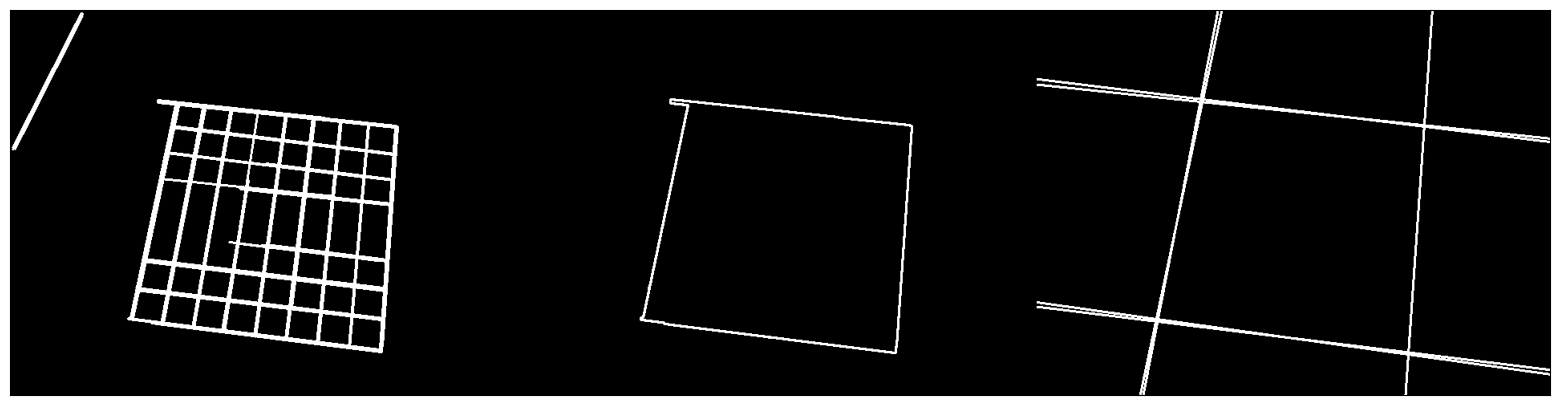

6


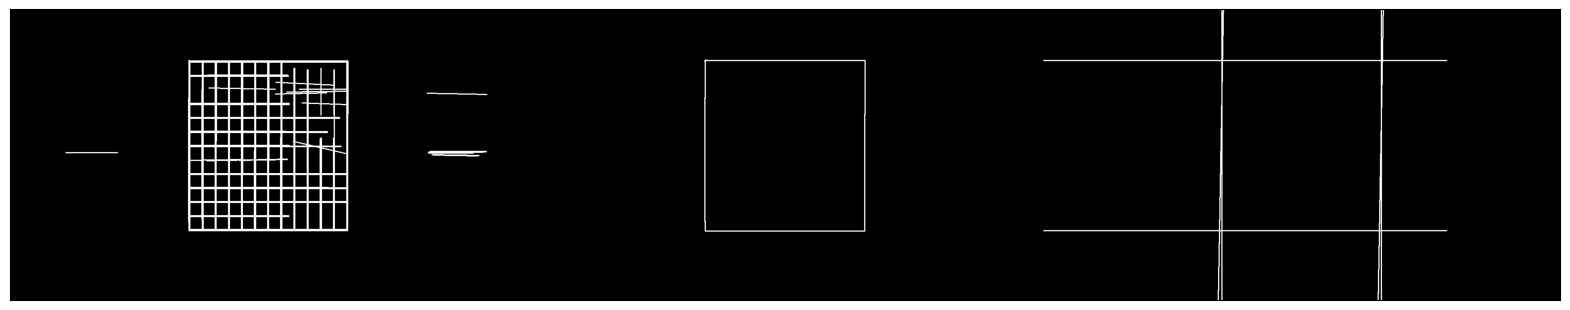

16


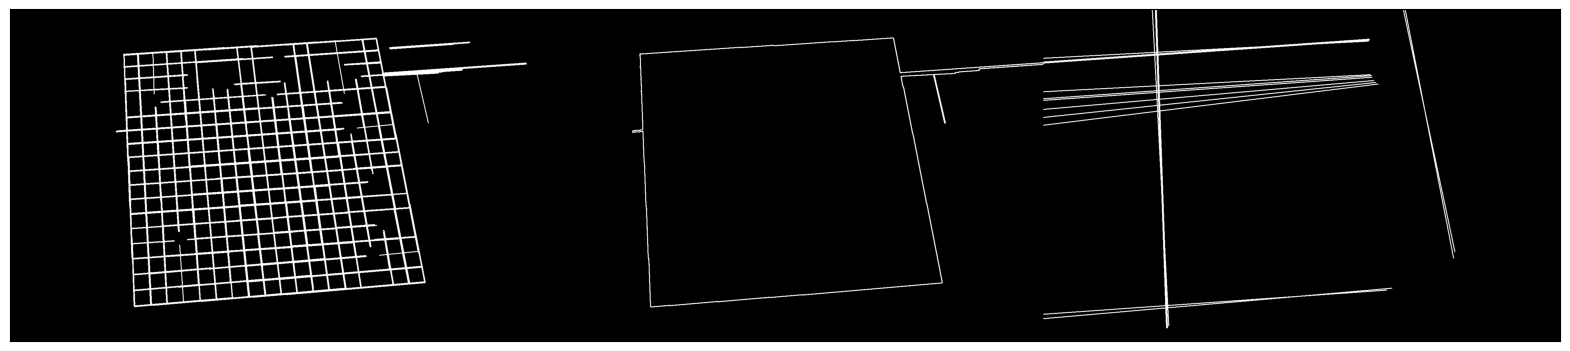

9


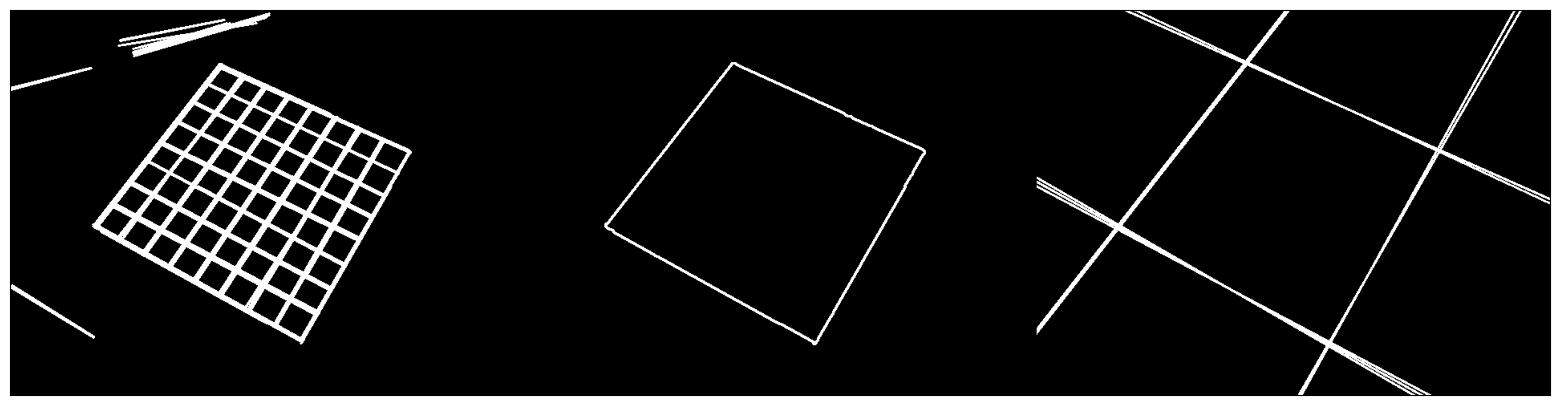

11


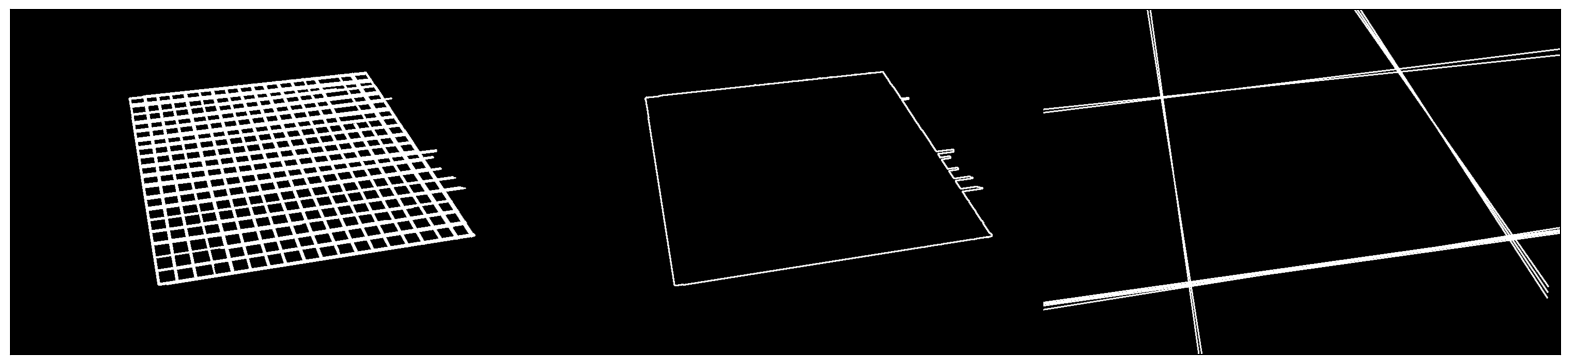

7


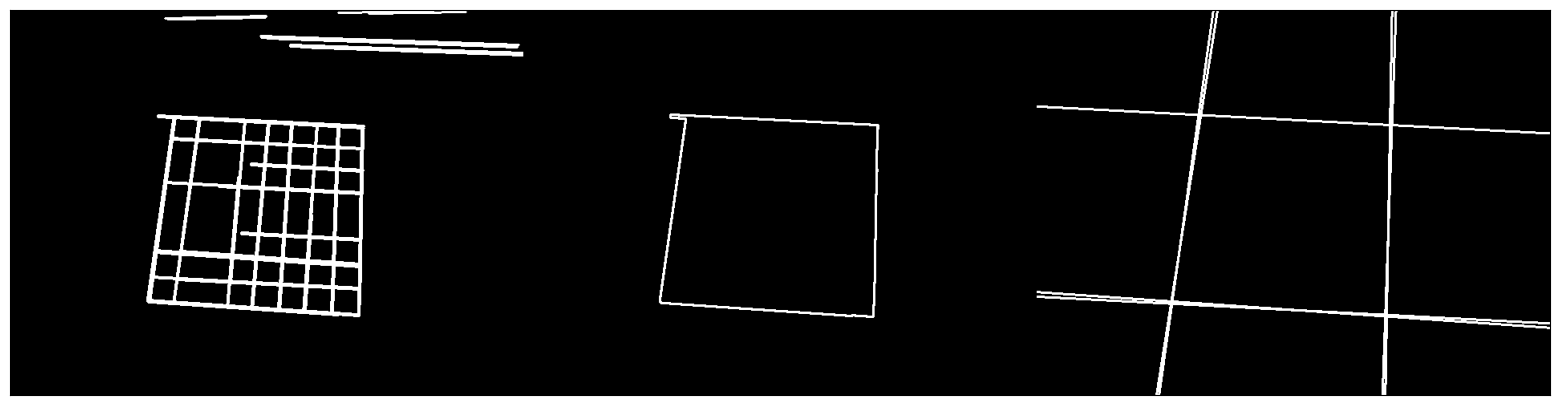

7


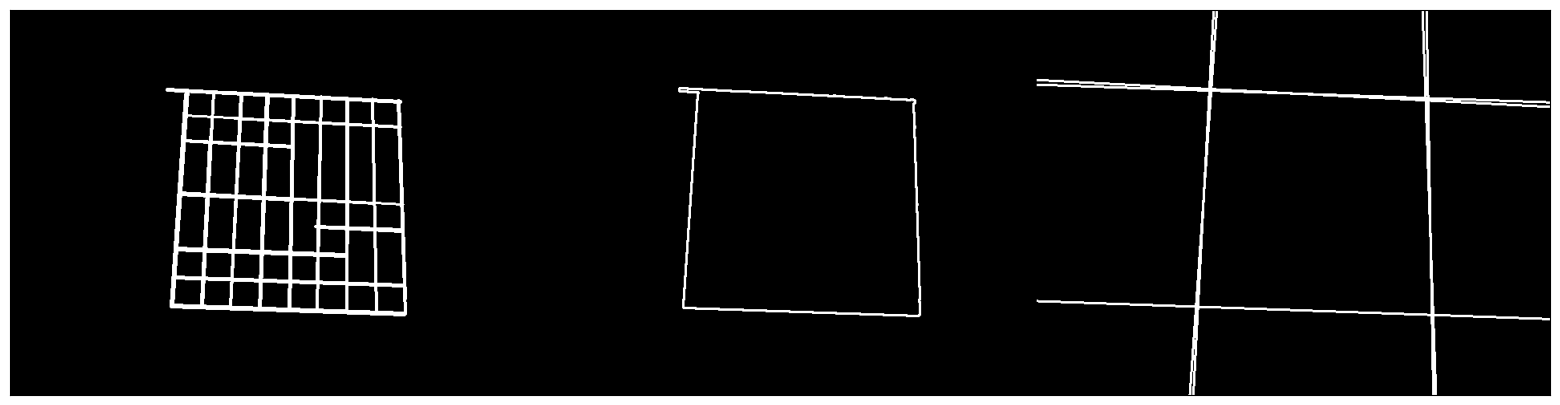

9


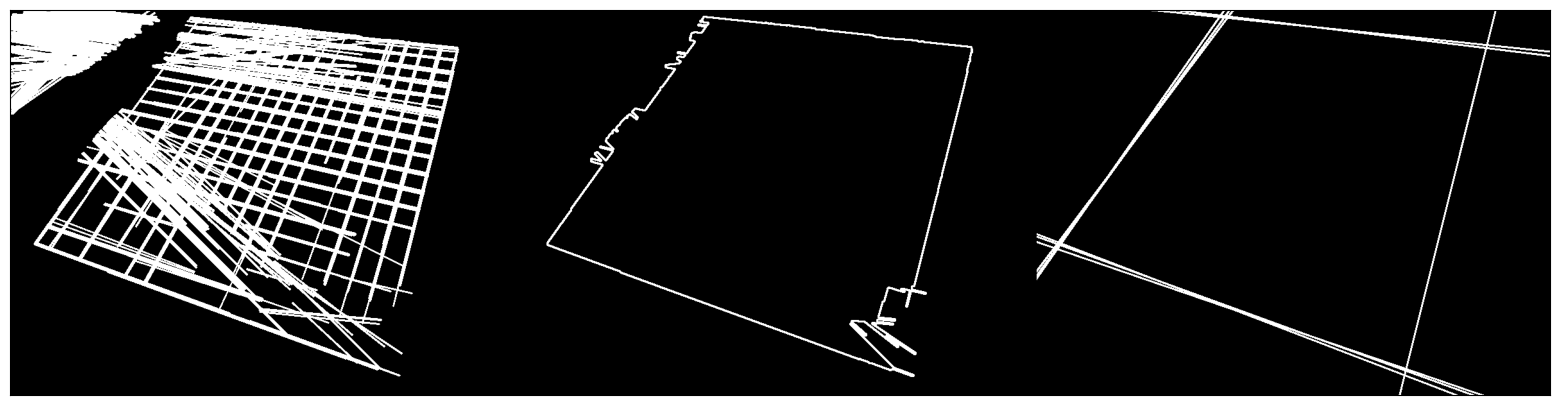

4


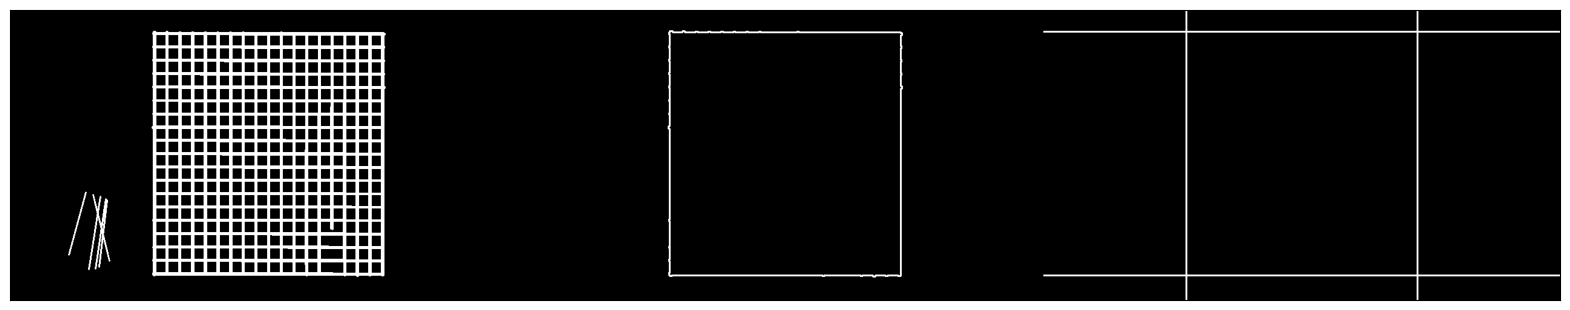

In [92]:
for img in imgs:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, OR = line_filter(gray)
    dilated = cv.dilate(OR, np.ones((3,3), np.uint8))
    lines = cv.HoughLinesP(dilated, 1, np.pi/180, 100, minLineLength=100, maxLineGap=30)
    tmp = np.zeros_like(gray)
    tmp = draw_lines(tmp, lines)

    contours, hierarchy = cv.findContours(tmp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    biggest = max(contours, key=lambda x: cv.contourArea(x))

    noisy_board = np.zeros_like(gray)
    cv.drawContours(noisy_board, [biggest], -1, 255, 2) # type: ignore

    border = np.zeros_like(gray)
    lines = approximate_quadriliteral(noisy_board)
    draw_lines_polar(border, lines)

    imshow(np.concatenate([tmp, noisy_board, border], axis=1), size=(20, 5))

        